Example Dependent Cost Sensitive Classification

Team Members\
CS21BTECH11060: Varun Gupta\
MA22BTECH11015: Priyanshu Goyal\
AI22BTECH11020: Pranay Jain

Imports and Data Handling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from functools import lru_cache
from scipy.special import gamma
from scipy.optimize import root_scalar

# Load the data
df_fraud = pd.read_csv("costsensitiveregression.csv")

# Reorder columns: move second-to-last column first, then everything else, then last column
cols = df_fraud.columns.tolist()
cols = cols[-2:-1] + cols[:-2] + cols[-1:]
df_fraud = df_fraud[cols]

# Split label (col 0) from features (col 1..end)
X_train_full, X_test_full, y_train, y_test = train_test_split(
    df_fraud.iloc[:, 1:],  # features
    df_fraud.iloc[:, 0],   # label
    test_size=0.2,
    random_state=0
)

# Separate out the false negative cost column "FNC"
cost_train = X_train_full["FNC"]
cost_test = X_test_full["FNC"]

# Drop the cost column from features
X_train_full = X_train_full.drop("FNC", axis=1)
X_test_full = X_test_full.drop("FNC", axis=1)

# Convert everything to NumPy
X_train = X_train_full.to_numpy()
X_test = X_test_full.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
cost_train = cost_train.to_numpy()
cost_test = cost_test.to_numpy()

Utility Functions

In [2]:
def sigmoid_function(z):
    """Applies the sigmoid transformation elementwise."""
    return 1.0 / (1.0 + np.exp(-z))

def compute_inverse_gamma(val):
    """
    Approximate the inverse of the gamma function for a given positive 'val'.
    Uses root finding to solve gamma(x) - val = 0 within a bracket.
    """
    def gamma_equation(x, target):
        return gamma(x) - target
    
    # Add a small offset to avoid zero
    bracket_result = root_scalar(
        gamma_equation, 
        args=(val + 1e-8,), 
        bracket=[-1e-18, 100]
    )
    if not bracket_result.converged:
        raise ValueError("Inverse gamma could not be computed.")
    return bracket_result.root

Cost Functions

In [3]:
def cost_bahnsen_approach(true_labels, predictions, fn_cost):
    """
    Bahnsen cost function:
    - true positive cost (tpc) = 6
    - false positive cost (fpc) = 6
    - true negative cost (tnc) = 0
    - false negative cost (fnc) is row-dependent (fn_cost).
    
    Note: 'predictions' are the sigmoid outputs, not 0/1 classes.
    """
    tpc = 6
    fpc = 6
    tnc = 0
    # The formula here uses predictions in place of 'h(x)'
    # y * [h(x)*TP + (1 - h(x))*FN] + (1 - y) * [h(x)*FP + (1 - h(x))*TN]
    # However, there's a slight mismatch: it uses (1 - y_pred) again in the second term,
    # so it effectively lumps them. We'll keep the structure for equivalence.
    combined_loss = (
        true_labels * (predictions * tpc + (1.0 - predictions) * fn_cost)
        + (1.0 - predictions) * (predictions * fpc + (1.0 - predictions) * tnc)
    )
    return np.mean(combined_loss)


def cost_nikou_approach(true_labels, predictions, fn_cost):
    """
    Nikou cost function:
    - false positive cost (fpc) = 6
    - row-based false negative cost (fn_cost)
    
    b = (1-y)*Gamma^-1(fpc) + y*Gamma^-1(fn_cost)
    a = 1 / Gamma(b + 1)
    Loss = a*y*(-log(pred))^b + a*(1-y)*(-log(1-pred))^b
    """
    fpc = 6
    # Clip predictions to avoid log(0)
    preds_clipped = np.clip(predictions, 1e-8, 1 - 1e-8)
    
    # Compute b row by row
    b_vals = []
    for i in range(len(true_labels)):
        if true_labels[i] == 1:
            # Use row-based FN
            b_vals.append(1.0 / gamma(fn_cost[i]))
        else:
            # Use FP cost
            b_vals.append(1.0 / gamma(fpc))
    b_vals = np.array(b_vals)
    
    # a = 1 / Gamma(b+1)
    a_vals = 1.0 / gamma(b_vals + 1.0)
    
    # Compute the loss per row
    # For y=1: a * ((-log(pred))^b)
    # For y=0: a * ((-log(1 - pred))^b)
    term_1 = true_labels * np.power(-np.log(preds_clipped), b_vals)
    term_2 = (1.0 - true_labels) * np.power(-np.log(1 - preds_clipped), b_vals)
    total_loss = a_vals * (term_1 + term_2)
    
    return np.mean(total_loss)

Genetic Algorithm Utilities

In [4]:
def calculate_fitness(pop, X, y, fn_cost, cost_func):
    """
    Fitness = 1 / (1 + cost), so lower cost => higher fitness.
    """
    scores = []
    for individual in pop:
        preds = sigmoid_function(X @ individual)
        cval = cost_func(y, preds, fn_cost)
        scores.append(1.0 / (1.0 + cval))
    return scores

def perform_crossover(parent_a, parent_b):
    """Single-point crossover at a random index."""
    point = np.random.randint(len(parent_a))
    offspring = np.concatenate([parent_a[:point], parent_b[point:]])
    return offspring

def perform_mutation(weights, mutation_prob):
    """
    Randomly perturb 'weights' in positions chosen by a Bernoulli mask
    with probability 'mutation_prob'.
    """
    mask = np.random.binomial(1, mutation_prob, size=len(weights)).astype(bool)
    weights[mask] += (np.random.rand(mask.sum()) - 0.5)
    return weights


Genetic Algorithm Training

In [5]:
def train_genetic_algorithm(
    population_size, 
    num_iterations, 
    mutation_probability, 
    X, 
    y, 
    fn_cost, 
    cost_func
):
    """
    - population_size: number of candidate solutions
    - num_iterations: GA loop count
    - mutation_probability: chance of mutating each gene
    - X, y, fn_cost: data
    - cost_func: either Bahnsen or Nikou cost function
    
    Returns: final population and a list of losses per iteration (for plotting).
    """
    # Track cost each iteration
    loss_history = []
    
    # Initialize random population in [-0.5, 0.5]
    population = np.random.rand(population_size, X.shape[1]) - 0.5
    
    for iteration in range(num_iterations):
        # Calculate fitness for current population
        fitness_scores = calculate_fitness(population, X, y, fn_cost, cost_func)
        fitness_scores = np.array(fitness_scores)
        
        # Probability distribution for selecting parents
        prob_dist = fitness_scores / fitness_scores.sum()
        
        # Choose two parents
        idx_a = np.random.choice(range(population_size), p=prob_dist)
        idx_b = np.random.choice(range(population_size), p=prob_dist)
        
        parent_a = population[idx_a]
        parent_b = population[idx_b]
        
        # Create a child
        child = perform_crossover(parent_a, parent_b)
        child = perform_mutation(child, mutation_probability)
        
        # Evaluate child fitness
        child_score = calculate_fitness([child], X, y, fn_cost, cost_func)[0]
        
        # Identify worst solution in population
        worst_idx = np.argmin(fitness_scores)
        
        # Identify best solution for logging
        best_idx = np.argmax(fitness_scores)
        best_solution = population[best_idx]
        preds_best = sigmoid_function(X @ best_solution)
        current_loss = cost_func(y, preds_best, fn_cost)
        loss_history.append(current_loss)
        
        # Replace worst with child if child is better
        if child_score > fitness_scores[worst_idx]:
            population[worst_idx] = child
    
    return population, loss_history


Run the GA for the Bahnsen Approach

Final test cost (Bahnsen approach): 1.8046


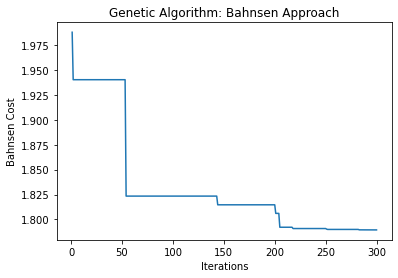

In [6]:
population_size = 50
num_iterations = 300
mutation_probability = 0.01

final_population, losses_over_epochs = train_genetic_algorithm(
    population_size,
    num_iterations,
    mutation_probability,
    X_train,
    y_train,
    cost_train,
    cost_bahnsen_approach
)

# Find the best solution in the final population
fitness_scores_final = calculate_fitness(final_population, X_train, y_train, cost_train, cost_bahnsen_approach)
best_index = np.argmax(fitness_scores_final)
best_solution = final_population[best_index]

# Evaluate on test set
preds_test = sigmoid_function(X_test @ best_solution)
final_test_cost = cost_bahnsen_approach(y_test, preds_test, cost_test)
print(f"Final test cost (Bahnsen approach): {final_test_cost:.4f}")

# Plot the loss curve
plt.figure()
plt.plot(range(1, num_iterations + 1), losses_over_epochs)
plt.xlabel("Iterations")
plt.ylabel("Bahnsen Cost")
plt.title("Genetic Algorithm: Bahnsen Approach")
plt.savefig("bahnsen_plot.png")
plt.show()


Run the GA for the Nikou Approach

In [ ]:
# Run GA for the Nikou cost-sensitive approach
population_size = 50
num_iterations = 300
mutation_probability = 0.01

final_pop_nikou, nikou_loss_history = train_genetic_algorithm(
    population_size,
    num_iterations,
    mutation_probability,
    X_train,
    y_train,
    cost_train,
    cost_nikou_approach  # our Nikou function defined earlier
)

# Identify the best candidate from the final population
fitness_nikou = calculate_fitness(final_pop_nikou, X_train, y_train, cost_train, cost_nikou_approach)
fitness_nikou = calculate_fitness(final_pop_nikou, X_train, y_train, cost_train, cost_nikou_approach)
best_idx_nikou = np.argmax(fitness_nikou)
best_candidate_nikou = final_pop_nikou[best_idx_nikou]

# Evaluate on test set using the Nikou approach
predictions_test_nikou = sigmoid_function(X_test @ best_candidate_nikou)
test_cost_nikou = cost_nikou_approach(y_test, predictions_test_nikou, cost_test)
print(f"Final test cost (Nikou approach): {test_cost_nikou:.4f}")

# Plot the loss evolution for the Nikou approach
plt.figure()
plt.plot(range(1, num_iterations + 1), nikou_loss_history)
plt.xlabel("Iterations")
plt.ylabel("Nikou Cost")
plt.title("Genetic Algorithm: Nikou Approach")
plt.savefig("nikou_plot.png")
plt.show()